In [1]:
import json
import pandas as pd
import time
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from glob import glob
from matplotlib.pylab import rcParams
from datetime import datetime, timedelta

rcParams['figure.figsize']=20,10
warnings.filterwarnings('ignore') # To ignore warnings.

In [2]:
# Import all holidays csv files
input_files = glob('./holidays*.csv')
holidays_df = pd.concat([pd.read_csv(file) for file in input_files])
holidays_df = holidays_df.reset_index(drop=True)
holidays_df.Date = holidays_df.Date.apply(lambda x: datetime.strptime(x, '%d.%m.%y')) # Convert the date string in datetime object
holidays_df.rename(columns = {'Date':'date'}, inplace = True)

In [3]:
# Import all csv files
input_files = glob('./DB*.csv')
result_df = pd.concat([pd.read_csv(file) for file in input_files])
result_df = result_df.reset_index(drop=True)

In [4]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152330 entries, 0 to 152329
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   name       152330 non-null  object 
 1   date       152330 non-null  object 
 2   departure  152330 non-null  object 
 3   arrival    152330 non-null  object 
 4   time       152330 non-null  object 
 5   products   152330 non-null  object 
 6   price      152330 non-null  float64
 7   weekday    152330 non-null  int64  
 8   validity   152330 non-null  int64  
 9   route      152330 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 11.6+ MB


In [5]:
date2 = result_df.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
hrs = result_df.departure.apply(lambda x: datetime.strptime(x,"%H:%M"))
# ...and use datetime's hour, min and sec properties to build a timedelta
delta = hrs.apply(lambda x: timedelta(hours=x.hour, minutes=x.minute, seconds=x.second))

result_df['STD'] = date2 + delta

In [6]:
result_df['date'] = result_df.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [7]:
# Import holidays data

result_df = result_df.merge(holidays_df, on='date', how='left')   # https://stackoverflow.com/questions/53645882/pandas-merging-101

In [8]:
result_df.validity = result_df.validity.apply(lambda x: datetime.fromtimestamp(x/1000)) # transform the unix timestamp in a timestamp timestamp

deltah = (result_df.STD - result_df.validity)

result_df['dhours'] = deltah.apply(lambda x: x.total_seconds() // 3600)
result_df['dday'] = deltah.apply(lambda x: x.days)

In [9]:
# drop all results with a price above 80 euros (first class tickets usually)
result_df = result_df.drop(result_df[(result_df['price'] > 80)].index)

In [10]:
# Check for missing values

missing_values = result_df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending = False)
NAN_col = list(missing_values.to_dict().keys())
missing_values_data = pd.DataFrame(missing_values)
missing_values_data.reset_index(level=0, inplace=True)
missing_values_data.columns = ['Feature','Number of Missing Values']
missing_values_data['Percentage of Missing Values'] = (100.0*missing_values_data['Number of Missing Values'])/len(result_df)
missing_values_data

,Feature,Number of Missing Values,Percentage of Missing Values


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe5c60436d0>,
      dtype=object)

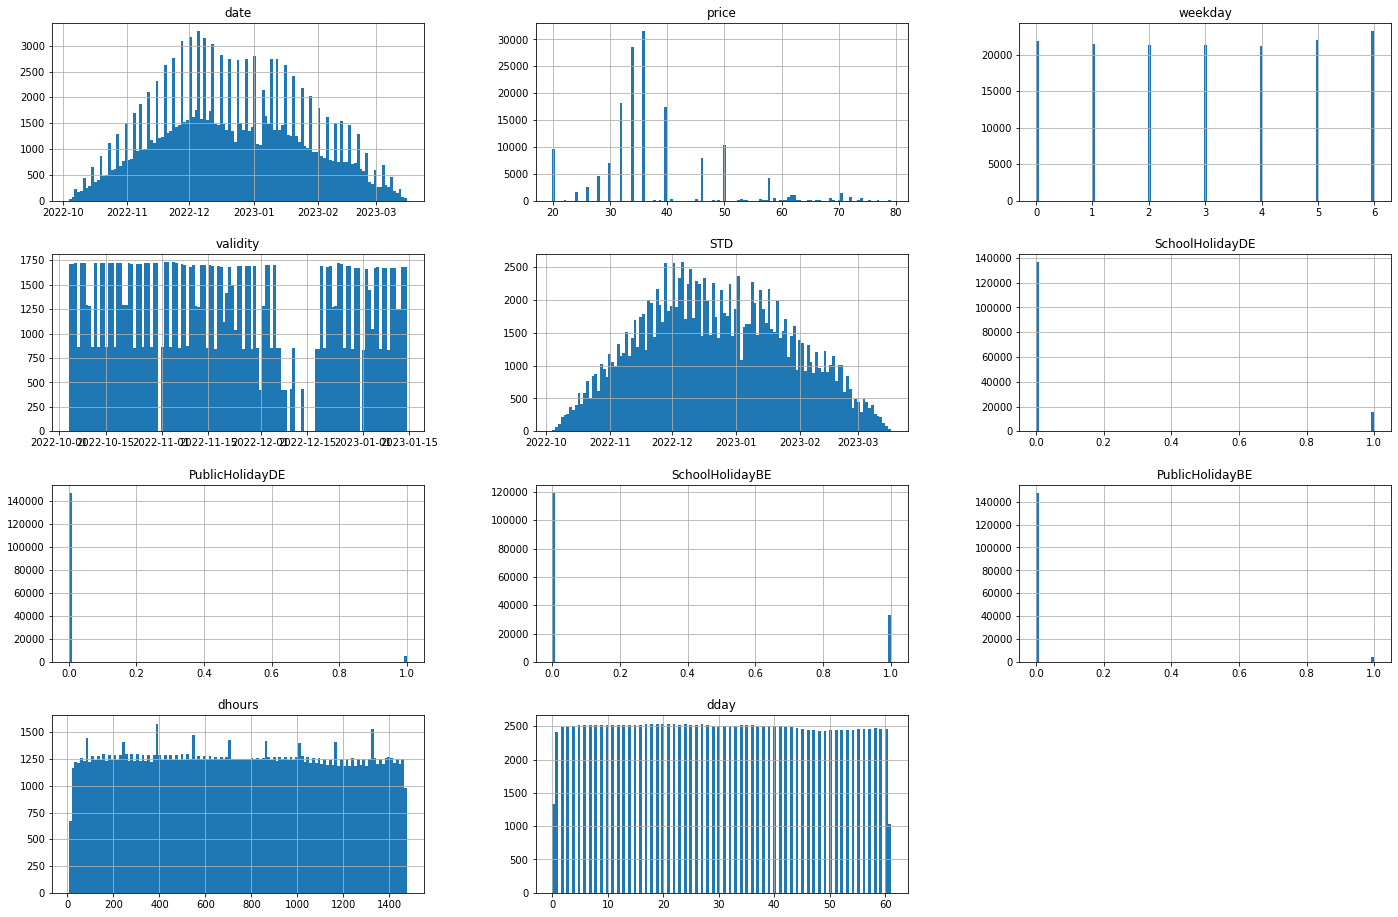

In [11]:
result_df.hist(bins=121, figsize=(24,16))

In [12]:
# Price categories

np.sort(result_df.price.unique())

array([19.9, 21.9, 23.9, 25.9, 27.9, 29.9, 31.9, 33.9, 35.9, 37.9, 38.9,
       39.9, 40.9, 44.9, 45.9, 48.1, 48.9, 49.9, 50.2, 52.2, 52.8, 52.9,
       53.4, 54.1, 56.2, 56.4, 56.8, 57.5, 57.9, 58.6, 58.8, 60. , 60.1,
       60.2, 60.9, 61.1, 61.9, 62.3, 62.7, 63.1, 64.9, 65.3, 65.8, 66. ,
       66.1, 66.7, 67.8, 68.5, 68.6, 69. , 69.3, 70. , 70.3, 71.8, 71.9,
       72.2, 72.5, 72.6, 73.3, 73.4, 74. , 75.3, 75.5, 77. , 79.1])

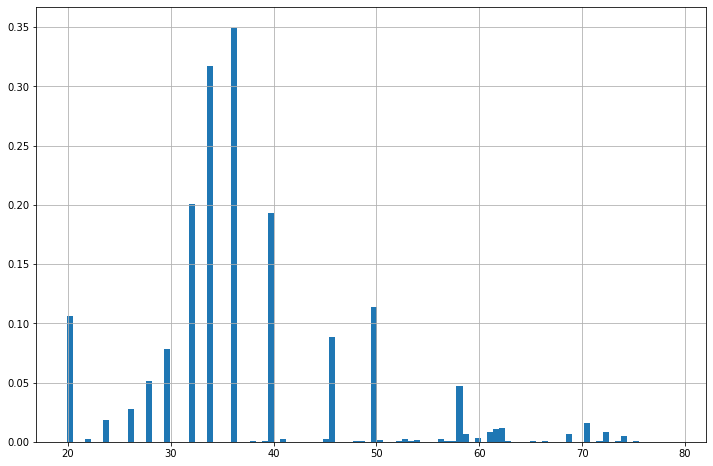

In [16]:
result_df.price.hist(bins = 100, figsize=(12,8), density = True)

Creating test sets

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(result_df, result_df['weekday']):   # homogeneous weekday in the sets
      strat_train_set_n = result_df.iloc[train_index]
      strat_test_set_n = result_df.iloc[test_index]
      strat_splits.append([strat_train_set_n, strat_test_set_n])

In [20]:
strat_train_set, strat_test_set = strat_splits[0]

In [21]:
strat_test_set['weekday'].value_counts() / len(strat_test_set)

6    0.152177
5    0.144421
0    0.143270
1    0.140641
2    0.140444
3    0.140214
4    0.138833
Name: weekday, dtype: float64

Explore data

In [22]:
dbdata = strat_train_set.copy()

In [23]:
corr_matrix = dbdata.corr()
corr_matrix['price'].sort_values(ascending=False)

price              1.000000
SchoolHolidayBE    0.225026
SchoolHolidayDE    0.204393
weekday            0.101611
PublicHolidayBE    0.066909
PublicHolidayDE    0.050635
dday              -0.500488
dhours            -0.501107
Name: price, dtype: float64

Add attributes, prepare data

In [24]:
dbdata = strat_train_set[['departure', 'weekday', 'dday', 'SchoolHolidayBE', 'SchoolHolidayDE', 'PublicHolidayBE', 'PublicHolidayDE']]
dbdata_labels = strat_train_set['price'].copy()

In [25]:
dbdata['departure'] = dbdata.departure.apply(lambda x: int(x[0:2]))  # keep only the hours and get rid of the minutes

In [26]:
dbdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121700 entries, 139109 to 145182
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype
---  ------           --------------   -----
 0   departure        121700 non-null  int64
 1   weekday          121700 non-null  int64
 2   dday             121700 non-null  int64
 3   SchoolHolidayBE  121700 non-null  int64
 4   SchoolHolidayDE  121700 non-null  int64
 5   PublicHolidayBE  121700 non-null  int64
 6   PublicHolidayDE  121700 non-null  int64
dtypes: int64(7)
memory usage: 7.4 MB


Pipeline with scaling and transformation

In [27]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

num_attribs = ['departure', 'dday', 'SchoolHolidayBE', 'SchoolHolidayDE', 'PublicHolidayBE', 'PublicHolidayDE']

cat_attribs = ['weekday']

cat_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore"))

num_pipeline = make_pipeline(StandardScaler())

preprocessing = ColumnTransformer([
      ("num", num_pipeline, num_attribs),
      ("cat", cat_pipeline, cat_attribs),
])

In [28]:
dbdata_prepared = preprocessing.fit_transform(dbdata)

In [30]:
# check the final categories
preprocessing.get_feature_names_out()

array(['num__departure', 'num__dday', 'num__SchoolHolidayBE',
       'num__SchoolHolidayDE', 'num__PublicHolidayBE',
       'num__PublicHolidayDE', 'cat__weekday_0', 'cat__weekday_1',
       'cat__weekday_2', 'cat__weekday_3', 'cat__weekday_4',
       'cat__weekday_5', 'cat__weekday_6'], dtype=object)

## Train the model

RandomForest

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(n_estimators = 50, random_state=42))
forest_reg.fit(dbdata, dbdata_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['departure', 'dday',
                                                   'SchoolHolidayBE',
                                                   'SchoolHolidayDE',
                                                   'PublicHolidayBE',
                                                   'PublicHolidayDE']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['weekday'])])),
                ('randomforestregressor',
                 R

In [39]:
dbdata_predictions = forest_reg.predict(dbdata)
forest_rmse = mean_squared_error(dbdata_labels, dbdata_predictions, squared=False) # squared to False means RMSE
forest_rmse

4.730974448970785

In [33]:
# cross validations
forest_rmses = -cross_val_score(forest_reg, dbdata, dbdata_labels, scoring="neg_root_mean_squared_error", cv=10)

In [38]:
pd.Series(forest_rmses).describe()

count    10.000000
mean      5.411522
std       0.086101
min       5.261810
25%       5.335295
50%       5.449075
75%       5.472091
max       5.511378
dtype: float64

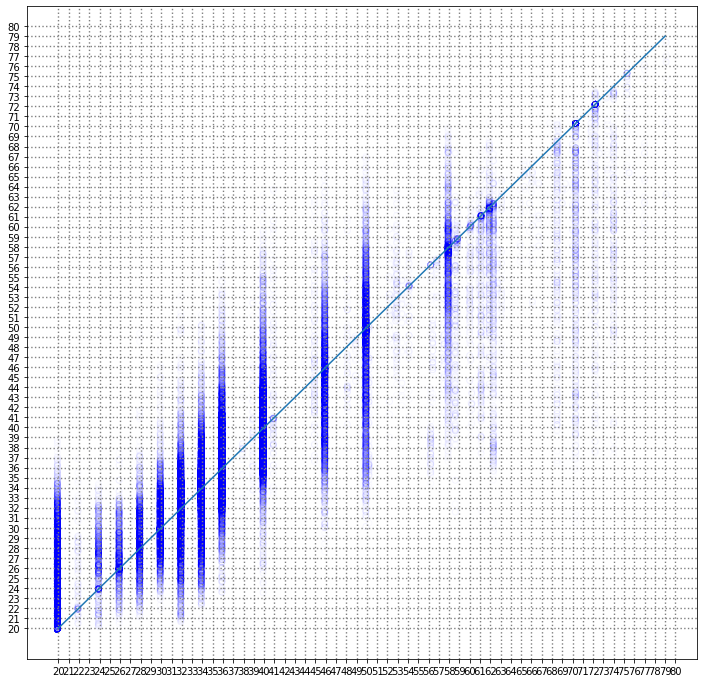

In [45]:
# Plot actual prices vs predictions

x = np.arange(20,80,1)
y = x
plt.figure(figsize=(12,12))
plt.scatter(dbdata_labels, dbdata_predictions, alpha = 0.02, marker = 'o', facecolors='none', edgecolor = 'blue')
plt.plot(x,y)
plt.xticks(np.arange(20, 81, 1))
plt.yticks(np.arange(20, 81, 1))
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = 'dotted')

## Fine tuning Random Forest

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(n_estimators = 50, random_state=42)),
])

param_grid = [
    {'random_forest__max_features': [8, 10, 12, 14, 16]},
]

forest_grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                            scoring='neg_root_mean_squared_error')

forest_grid_search.fit(dbdata, dbdata_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['departure',
                                                                          'dday',
                                                                          'SchoolHolidayBE',
                                                                          'SchoolHolidayDE',
                                                                          'PublicHolidayBE',
                                                                          'PublicHolidayDE']),
                                                                        ('cat',
  

In [47]:
forest_grid_search.best_params_

{'random_forest__max_features': 12}

In [48]:
cv_res = pd.DataFrame(forest_grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_forest__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
2,4.518910,0.190008,0.457134,0.033117,12,{'random_forest__max_features': 12},-5.557128,-5.496899,-5.444537,-5.499521,0.046003,1
1,4.370401,0.315667,0.418641,0.004334,10,{'random_forest__max_features': 10},-5.556609,-5.498417,-5.444195,-5.499741,0.045903,2
0,3.597438,0.298090,0.429030,0.012947,8,{'random_forest__max_features': 8},-5.558121,-5.500764,-5.449595,-5.502827,0.044330,3
3,0.043093,0.002197,0.000000,0.000000,14,{'random_forest__max_features': 14},NaN,NaN,NaN,NaN,NaN,4
4,0.038870,0.000174,0.000000,0.000000,16,{'random_forest__max_features': 16},NaN,NaN,NaN,NaN,NaN,5


Analysing the best models and their errors

In [49]:
final_model = forest_grid_search.best_estimator_

In [50]:
forest_feature_importances = final_model["random_forest"].feature_importances_

In [51]:
sorted(zip(forest_feature_importances, final_model["preprocessing"].get_feature_names_out()), reverse=True)

[(0.4905176541131516, 'num__dday'),
 (0.2648846783837179, 'num__departure'),
 (0.05759104973775391, 'num__SchoolHolidayBE'),
 (0.039639902830835815, 'num__SchoolHolidayDE'),
 (0.02891446706258406, 'cat__weekday_4'),
 (0.028889858950438246, 'cat__weekday_1'),
 (0.026020797963558804, 'cat__weekday_6'),
 (0.01985588910392936, 'cat__weekday_2'),
 (0.011997999422813769, 'cat__weekday_0'),
 (0.010296572416992134, 'cat__weekday_5'),
 (0.009220707677617975, 'num__PublicHolidayBE'),
 (0.008689918599904386, 'cat__weekday_3'),
 (0.003480503736702019, 'num__PublicHolidayDE')]

## evaluate the model on the test set

In [52]:
X_test = strat_test_set.drop("price", axis=1)

X_test['departure'] = X_test.departure.apply(lambda x: int(x[0:2]))

y_test = strat_test_set["price"].copy()

final_predictions = final_model.predict(X_test)

In [53]:
final_rmse = mean_squared_error(y_test, final_predictions, squared=False) 

print(final_rmse)

5.412789374213895


In [54]:
vis_res = strat_test_set.drop(['route', 'STD', 'dhours', 'dday', 'arrival', 'time'], axis=1)
vis_res['Forest_prediction'] = final_predictions.round(1)
vis_res = vis_res[['name', 'validity', 'weekday', 'price', 'Forest_prediction']]
vis_res['delta_Forest'] = vis_res.price -  vis_res.Forest_prediction
vis_res['delta_Forest'] = vis_res.delta_Forest.round(1)
vis_res

,name,validity,weekday,price,Forest_prediction,delta_Forest
52990,ICE_CB_20221201_1530,2022-10-14 08:19:00,3,33.9,37.1,-3.2
7104,ICE_BC_20230115_1625,2022-11-28 19:20:00,6,33.9,36.1,-2.2
36870,ICE_CB_20230124_0942,2022-11-26 20:24:00,1,19.9,23.6,-3.7
79580,ICE_BC_20221125_1825,2022-10-20 19:14:00,4,35.9,36.0,-0.1
63355,ICE_CB_20221203_0730,2022-10-09 10:00:00,5,29.9,27.7,2.2
...,...,...,...,...,...,...
15088,ICE_BC_20221214_0823,2022-11-05 07:16:00,2,31.9,28.7,3.2
80175,ICE_CB_20221205_1330,2022-10-06 08:00:00,0,39.9,36.1,3.8
86431,ICE_CB_20221104_1741,2022-10-06 20:00:00,4,72.2,70.4,1.8
96689,ICE_CB_20221030_1540,2022-10-12 08:00:00,6,45.9,49.2,-3.3


In [55]:
print('% of Forest predictions exactly right')
print(len(vis_res[(vis_res.delta_Forest <= 0.2) & (vis_res.delta_Forest >= -0.2)]) / len(vis_res))
print('% of Forest predictions between -2 and 2 euros')
print(len(vis_res[(vis_res.delta_Forest <= 2) & (vis_res.delta_Forest >= -2)]) / len(vis_res))
print('% of Forest predictions between -5 and 5 euros')
print(len(vis_res[(vis_res.delta_Forest <= 5) & (vis_res.delta_Forest >= -5)]) / len(vis_res))

% of Forest predictions exactly right
0.12407559572719803
% of Forest predictions between -2 and 2 euros
0.48736236647493836
% of Forest predictions between -5 and 5 euros
0.7733771569433032


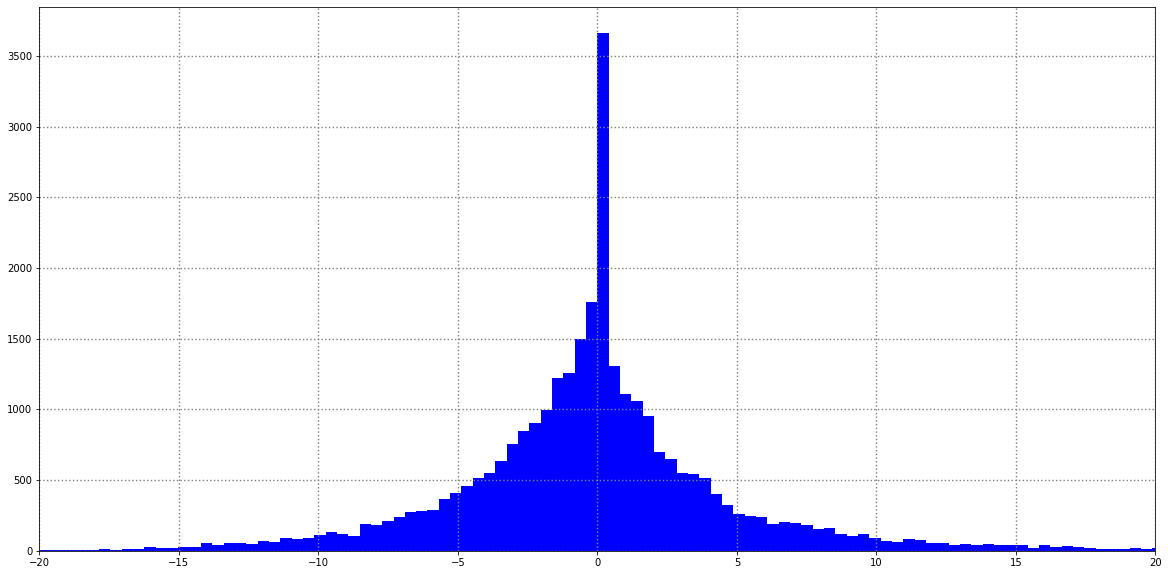

In [57]:
plt.hist(vis_res.delta_Forest, bins = 200, density = False, color = 'blue')

plt.xlim([-20, 20])

plt.plot()
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = 'dotted')

confidence intervals

In [60]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2

np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([5.32687018, 5.49736589])

### Test on new data

In [61]:
weekdays = [0, 1]
ddays = [46, 47]
departures = [10, 10]
schoolDE = [0, 0]
schoolBE = [0, 0]
publicDE = [0, 0]
publicBE = [0, 0]

test_df = pd.DataFrame({'departure':departures, 'weekday':weekdays, 'dday':ddays, 'SchoolHolidayBE': schoolBE, 'SchoolHolidayDE': schoolDE, 'PublicHolidayBE': publicBE, 'PublicHolidayDE': publicDE})

In [62]:
test_df

,departure,weekday,dday,SchoolHolidayBE,SchoolHolidayDE,PublicHolidayBE,PublicHolidayDE
0,10,0,46,0,0,0,0
1,10,1,47,0,0,0,0


In [63]:
test_predictions = final_model.predict(test_df)

In [64]:
test_predictions.round(1)

array([32.4, 31.2])

In [65]:
test_preds = []
test_ddays = np.arange(1,30,1)

for i in test_ddays:

  test_preds.append(final_model.predict(pd.DataFrame({'departure':[17], 'weekday':[2], 'dday':[i], 'SchoolHolidayBE': [0], 'SchoolHolidayDE': [0], 'PublicHolidayBE': [0], 'PublicHolidayDE': [0]})).round(1)[0])

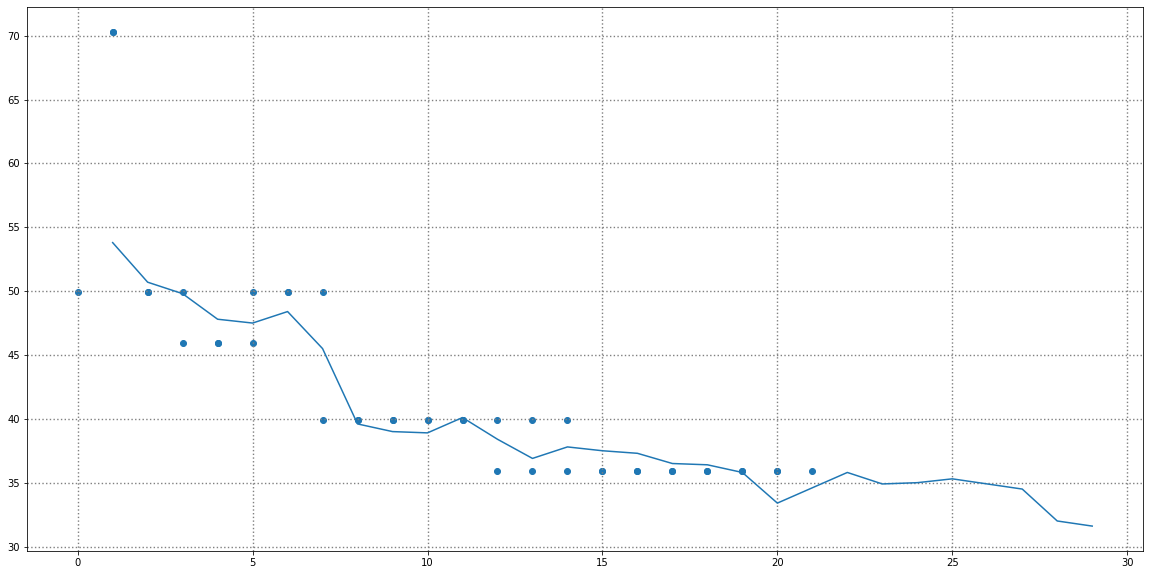

In [67]:
# compare actual vs predicated prices visually
plt.plot(test_ddays, test_preds)
plt.scatter(result_df[result_df.name == 'ICE_CB_20221130_1750'].dday, result_df[result_df.name == 'ICE_CB_20221130_1750'].price)
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = 'dotted')

## Save the model

In [68]:
import joblib

joblib.dump(final_model, "random_forest_prices_model_140123_1.pkl")

['random_forest_prices_model_140123_1.pkl']

## Import and test model

In [69]:
import joblib

model_from_joblib = joblib.load('random_forest_prices_model_140123_1.pkl')

In [70]:
test_preds = []
test_ddays = np.arange(1,30,1)

for i in test_ddays:

  test_preds.append(model_from_joblib.predict(pd.DataFrame({'departure':[17], 'weekday':[3], 'dday':[i], 'SchoolHolidayBE': [0], 'SchoolHolidayDE': [0], 'PublicHolidayBE': [0], 'PublicHolidayDE': [0]})).round(1)[0])

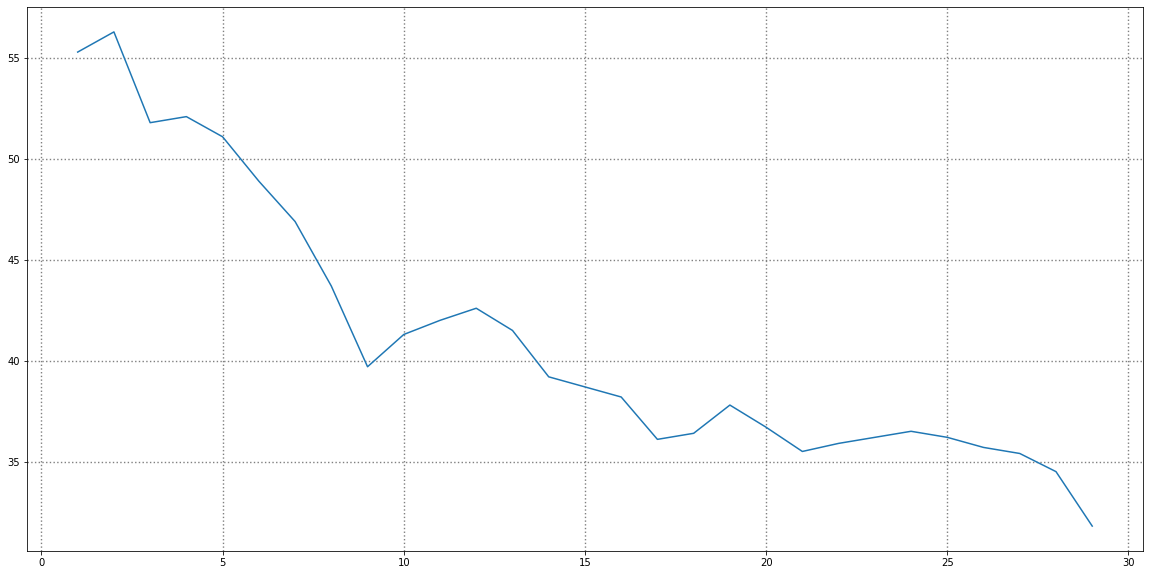

In [71]:
plt.plot(test_ddays, test_preds)

plt.grid(True, color = "grey", linewidth = "1.4", linestyle = 'dotted')